In [86]:
include("src/Elise.jl");

In [87]:
Random.seed!(1234);

---

## Config

In [88]:
const cfg = Config(η=1e-5)
dump(cfg)

Config
  dt: Float64 0.1
  E_exc: Float64 1.0
  E_inh: Float64 -1.0
  g_l: Float64 0.1
  g_den: Float64 2.0
  g_e: Float64 0.3
  g_i: Float64 0.9
  δ: Float64 25.0
  η: Float64 1.0e-5
  λ: Float64 0.6
  a: Float64 21.0
  b: Float64 0.18


---

## Data

Reading target from midi file. We also get the needed number of output neurons (with possibly some silent in the middle, it is just the highest note - the lowest note) and the needed simulation time in ms.

In [66]:
T_min::Float64 = 0.
T_max::Float64 = 158 #T_end = size(Target, 2) / cfg.dt - cfg.dt

158

In [89]:
Targets::Vector{Matrix{Bool}} = [from_midi("Well Tempered Clavier/Preludes/Prelude"*string(i)*".mid") for i in [4,9,18,21]];
trim(M) = M[findfirst(i->any(M[i,:]),1:size(M,1)):findlast(i->any(M[i,:]),1:size(M,1)),
            findfirst(i->any(M[:,i]),1:size(M,2)):findlast(i->any(M[:,i]),1:size(M,2))]
Target::Matrix{Bool} = vcat([trim(t[:,1:1 + floor(Int,T_max*cfg.dt)]) for t in Targets]...)
target = t->Float64.(Target[:,1 + floor(Int,t*cfg.dt)]);

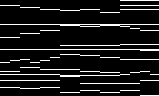

In [90]:
Gray.(reduce(hcat,[target(t) for t in T_min:T_max]))

---

## Parameters

In [91]:
N_out::Int = size(Target, 1)
N_latent::Int = 3 * N_out;
N::Int = N_out + N_latent;
(N=N, N_latent=N_latent, N_out=N_out)

(N = 384, N_latent = 288, N_out = 96)

In [92]:
W::Matrix{Float64} = rand(Normal(0., 0.0005), N, N);
const B::Matrix{Float64} = Float64.(rand(N_latent, N) .< 1.5/N);
const τ_d::Vector{Float64} = rand(Uniform(1., 20.), N);
const τ_s::Vector{Float64} = rand(Uniform(1., 20.), N);

In [93]:
args = [W, B, τ_d, τ_s, cfg, target, T_min, T_max];

---

## Training 

In [94]:
train!(args..., 100)

---

## Testing

In [95]:
θ::Float64 = 0.5;
metric = (r,t;θ=θ) -> sum((r.>θ).&(t.>θ)) / sum((r.>θ).|(t.>θ))
test!(args..., metric, N_out)

0.7812840043525572

In [96]:
N_run::Int = 5
nudge_on_run_nb(n) = n % 4 == 0
r, u, v = run!(args..., N_run, nudge_on_run_nb);

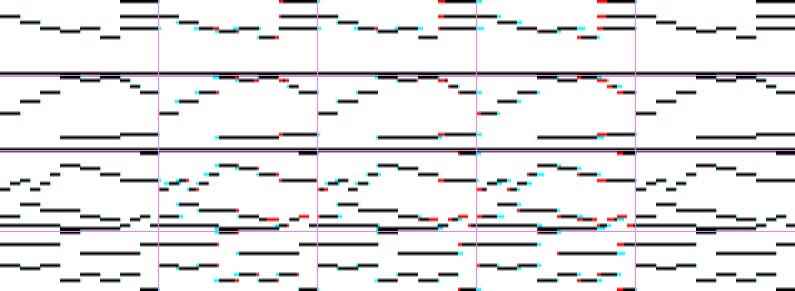

In [97]:
plot(r[1:N_out,:], target, T_min, T_max, N_run, θ, ratio=(3,1), vsizes=[25,50,77])

In [ ]:
using BenchmarkTools

u, v, rbar, m_den, m_som_exc, m_som_inh = initialize(τ_d, τ_s, cfg)
u_tgt_bench::Vector{Float64} = Float64.(rand(N_out).>3/4);

@benchmark step!($u, $u_tgt_bench, $v, $rbar, $W, $B, $cfg, $m_den, $m_som_exc, $m_som_inh)